## K-Means  
The following code carries out k-means clustering using simulated data

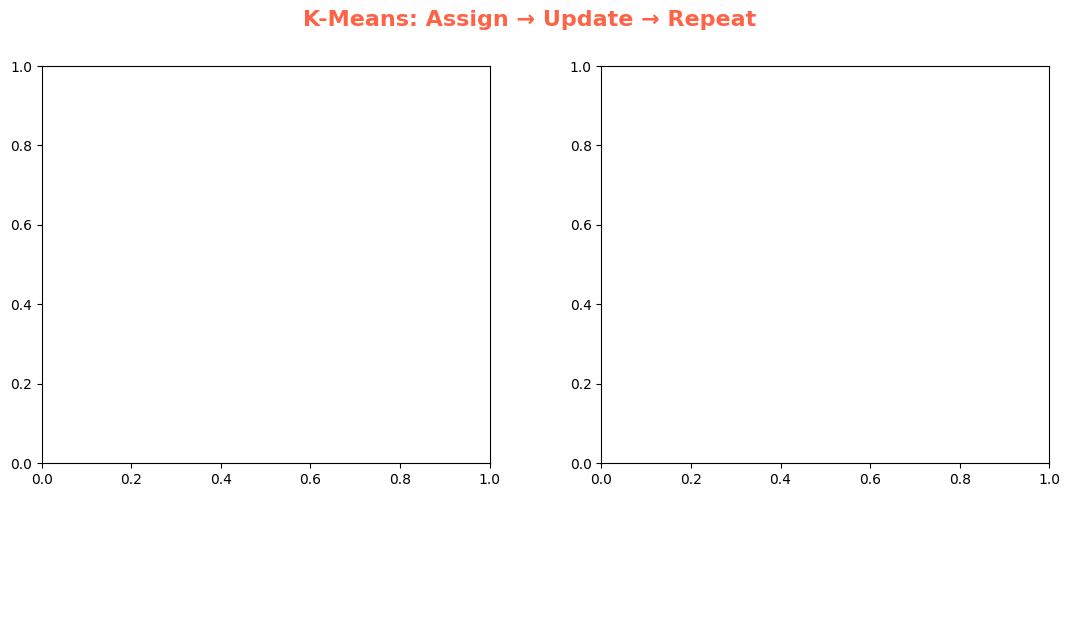

MovieWriter imagemagick unavailable; using Pillow instead.


In [12]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from sklearn.datasets import make_blobs

# ---------------------------
# 1) Data + K-Means helpers
# ---------------------------
np.random.seed(1031)
X, _ = make_blobs(n_samples=500, centers=6, cluster_std=6.0, random_state=1031)
k = 6
max_iter = 10

# Random centroid init
centroids = X[np.random.choice(X.shape[0], k, replace=False)]

def assign_clusters(X, centroids):
    # distances: (n_samples, k)
    distances = np.linalg.norm(X[:, None] - centroids[None, :], axis=2)
    return np.argmin(distances, axis=1)

def compute_centroids(X, labels, k):
    # Handle empty clusters by re-seeding those centroids from random points
    new_centroids = np.zeros((k, X.shape[1]))
    for i in range(k):
        pts = X[labels == i]
        if len(pts) == 0:
            # reinitialize this centroid to a random point to avoid NaNs
            new_centroids[i] = X[np.random.randint(0, X.shape[0])]
        else:
            new_centroids[i] = pts.mean(axis=0)
    return new_centroids

def compute_inertia(X, centroids, labels):
    return float(np.sum((X - centroids[labels])**2))

# Track history
centroids_hist = [centroids.copy()]
labels_hist    = [np.zeros(X.shape[0], dtype=int)]
inertia_hist   = [compute_inertia(X, centroids, labels_hist[0])]

for _ in range(max_iter):
    labels = assign_clusters(X, centroids)
    new_centroids = compute_centroids(X, labels, k)
    inertia = compute_inertia(X, new_centroids, labels)

    labels_hist.append(labels.copy())
    centroids_hist.append(new_centroids.copy())
    inertia_hist.append(inertia)

    centroids = new_centroids

# ---------------------------
# 2) Figure layout (no overlap)
# ---------------------------
plt.close('all')
fig = plt.figure(figsize=(13, 7))
# GridSpec with two rows: top row has two columns (scatter | inertia)
# bottom row spans both columns and is only for explanatory text
gs = fig.add_gridspec(nrows=2, ncols=2, height_ratios=[12, 3], width_ratios=[1, 1])
ax_scatter = fig.add_subplot(gs[0, 0])
ax_inertia = fig.add_subplot(gs[0, 1])
ax_explain = fig.add_subplot(gs[1, :])

# Overall title as a SUPTITLE (not in scatter axes)
fig.suptitle("K-Means: Assign → Update → Repeat", fontsize=16, color="tomato", fontweight="bold", y=0.98)

# Explanation panel styling (dedicated axes)
ax_explain.set_axis_off()     # no frame or ticks
exp_text = ax_explain.text(0.01, 0.7, "", fontsize=12, color="navy", va="center", ha="left")

# Make sure there's space for suptitle and bottom explanation row
plt.subplots_adjust(top=0.90, bottom=0.12, wspace=0.25)

# Color palette
colors = matplotlib.cm.Set2(np.arange(k))

# Precompute x/y limits for stability
xpad, ypad = 5, 5
xlim = (X[:, 0].min() - xpad, X[:, 0].max() + xpad)
ylim = (X[:, 1].min() - ypad, X[:, 1].max() + ypad)

# ---------------------------
# 3) Animation update
# ---------------------------
def frame_explanation(frame):
    if frame == 0:
        return "Step 1: Initialize cluster centers randomly."
    elif frame == 1:
        return "Step 2: Assign each point to its nearest center."
    elif frame == 2:
        return "Step 3: Update centers to the mean of assigned points."
    elif frame <= max_iter:
        return f"Iteration {frame}: Reassign → Update → Repeat."
    else:
        return "Converged clusters (inertia largely stabilized)."

def update(frame):
    # --- Left: scatter + centroids ---
    ax_scatter.clear()
    labels = labels_hist[min(frame, len(labels_hist)-1)]
    cents  = centroids_hist[min(frame, len(centroids_hist)-1)]

    for i in range(k):
        pts = X[labels == i]
        if len(pts):
            ax_scatter.scatter(pts[:, 0], pts[:, 1], s=25, color=colors[i], alpha=0.7)
    ax_scatter.scatter(cents[:, 0], cents[:, 1], marker='^', s=200, c=colors[:k], edgecolor='black')

    ax_scatter.set_xlim(xlim)
    ax_scatter.set_ylim(ylim)
    ax_scatter.set_xlabel("x₁")
    ax_scatter.set_ylabel("x₂")
    ax_scatter.set_title("Data & Centroids", pad=10)

    # --- Right: inertia curve ---
    ax_inertia.clear()
    # Show inertia up to current frame (cap at history length)
    upto = min(frame + 1, len(inertia_hist))
    iters = list(range(upto))
    ax_inertia.plot(iters, inertia_hist[:upto], 'o-', linewidth=2)
    ax_inertia.set_xlim(0, max_iter + 0.5)
    ax_inertia.set_xlabel("Iteration")
    ax_inertia.set_ylabel("Inertia (SSE)")
    ax_inertia.set_title("Inertia (Sum of Squared Distances)", pad=10)
    ax_inertia.grid(True, linestyle='--', alpha=0.5)

    # Annotate current inertia
    if upto > 0:
        ax_inertia.annotate(f"SSE = {inertia_hist[upto-1]:,.0f}",
                            xy=(iters[-1], inertia_hist[upto-1]),
                            xytext=(10, -10), textcoords="offset points",
                            fontsize=10, bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="gray", alpha=0.8))

    # --- Bottom: explanation (separate axes, no overlap) ---
    exp_text.set_text(frame_explanation(frame))

    return ax_scatter, ax_inertia, exp_text

ani = FuncAnimation(fig, update, frames=max_iter + 2, interval=1200, repeat=False)

plt.show()

# ---------------------------
# 4) Robust saving (no overlap, fallback writers)
# ---------------------------
def save_animation(ani, base_name="kmeans_with_inertia", fps=1):
    """
    Try MP4 (ffmpeg) first; if unavailable, fall back to GIF (pillow).
    Avoids the '.mp4 with Pillow' error.
    """
    try:
        # MP4 if ffmpeg present
        from matplotlib.animation import writers
        if 'ffmpeg' in writers.list():
            ani.save(f"{base_name}.mp4", writer="ffmpeg", fps=fps, dpi=150)
            print(f"Saved {base_name}.mp4 with ffmpeg.")
            return
        else:
            raise RuntimeError("ffmpeg not found, using GIF fallback.")
    except Exception as e:
        print(f"⚠️ {e}\nSaving GIF with Pillow instead...")
        ani.save(f"{base_name}.gif", writer="pillow", fps=fps, dpi=150)
        print(f"Saved {base_name}.gif with Pillow.")

# Example:
# save_animation(ani)

# Optional: Save animation
ani.save("kmeans_with_inertia.gif", writer="imagemagick", fps=0.3)
# ani.save("kmeans_with_inertia.mp4", writer="ffmpeg", fps=1)

## DBSCAN  
Following Code simulates the process of DBSCAN using simulated data. The illustration demonstrates the process without actually running DBSCAN algorithm. This was generated by vibe coding with chatGPT. 

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.patches import Circle
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

# ============================================================
# 1) Simulate Option A: two blobs + a little noise (2 features)
#    90 blob points + 10 noise points = 100 total
# ============================================================
np.random.seed(7)

X, _ = make_blobs(
    n_samples=90,
    centers=[(-2, -1), (2, 2)],   # two cluster centers
    cluster_std=[0.45, 0.55],     # cluster spreads
    random_state=7
)

# Add uniform noise points
rng = np.random.default_rng(7)
noise = rng.uniform(low=[-5, -4], high=[5, 5], size=(10, 2))
X = np.vstack([X, noise])  # total = 100 points

# Scale (DBSCAN is distance-based; scaling is best practice)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ============================================================
# 2) DBSCAN-from-scratch with snapshots for animation
# ============================================================
UNASSIGNED = -99
NOISE = -1

def region_query(X, i, eps):
    """Return indices of points within eps of point i (Euclidean)."""
    d = np.linalg.norm(X - X[i], axis=1)
    return np.where(d <= eps)[0]

def dbscan_with_snapshots(X, eps=0.35, min_samples=10, snapshot_every=10):
    """
    Simple DBSCAN implementation that records snapshots during expansion.
    labels:
      UNASSIGNED (-99) = not yet labeled
      NOISE (-1)       = noise
      0,1,2,...        = cluster ids
    """
    n = X.shape[0]
    labels = np.full(n, UNASSIGNED, dtype=int)
    visited = np.zeros(n, dtype=bool)

    snapshots = []
    meta = []  # (current_index, stage)

    cluster_id = 0
    steps = 0

    def snap(current_i, stage):
        snapshots.append(labels.copy())
        meta.append((current_i, stage))

    for i in range(n):
        if visited[i]:
            continue

        visited[i] = True
        neighbors = region_query(X, i, eps)

        # Not dense enough => noise for now (may later become border)
        if len(neighbors) < min_samples:
            labels[i] = NOISE
            snap(i, "noise_check")
            continue

        # Start new cluster
        labels[i] = cluster_id
        snap(i, "new_cluster_seed")

        # Expand cluster
        queue = list(neighbors)
        qpos = 0

        while qpos < len(queue):
            j = queue[qpos]
            qpos += 1

            if not visited[j]:
                visited[j] = True
                j_neighbors = region_query(X, j, eps)

                # If j is core, add its neighbors
                if len(j_neighbors) >= min_samples:
                    for nn in j_neighbors:
                        if nn not in queue:
                            queue.append(nn)

            # Assign to cluster if unassigned or previously noise
            if labels[j] in (UNASSIGNED, NOISE):
                labels[j] = cluster_id

            steps += 1
            if steps % snapshot_every == 0:
                snap(j, "expand_cluster")

        cluster_id += 1

    # Final snapshot
    snapshots.append(labels.copy())
    meta.append((None, "final"))

    return snapshots, meta

# Parameters that typically work well for two blobs in scaled space
eps = 0.35
min_samples = 10

snapshots, meta = dbscan_with_snapshots(
    X_scaled, eps=eps, min_samples=min_samples, snapshot_every=10
)

# ============================================================
# 3) Animate snapshots and save as GIF
# ============================================================
def label_to_rgba(lbl):
    if lbl == UNASSIGNED:
        return (0.85, 0.85, 0.85, 1.0)  # light gray
    if lbl == NOISE:
        return (0.30, 0.30, 0.30, 1.0)  # dark gray
    cmap = plt.get_cmap("tab10")
    return cmap(lbl % 10)

fig, ax = plt.subplots()
ax.set_title("DBSCAN Process")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")

sc = ax.scatter(X_scaled[:, 0], X_scaled[:, 1], s=22)

# eps circle is accurate because we are plotting the SAME scaled space DBSCAN uses
eps_circle = Circle((0, 0), radius=eps, fill=False, linewidth=2)
ax.add_patch(eps_circle)
eps_circle.set_visible(False)

info = ax.text(0.02, 0.98, "", transform=ax.transAxes, va="top")

# plot limits
pad = 0.5
ax.set_xlim(X_scaled[:, 0].min() - pad, X_scaled[:, 0].max() + pad)
ax.set_ylim(X_scaled[:, 1].min() - pad, X_scaled[:, 1].max() + pad)

def update(frame_idx):
    labels = snapshots[frame_idx]
    current_i, stage = meta[frame_idx]

    # point colors
    colors = np.array([label_to_rgba(l) for l in labels])
    sc.set_facecolors(colors)
    sc.set_edgecolors(colors)

    # eps neighborhood circle
    if current_i is None:
        eps_circle.set_visible(False)
    else:
        eps_circle.center = (X_scaled[current_i, 0], X_scaled[current_i, 1])
        eps_circle.set_visible(True)

    assigned = np.sum(labels >= 0)
    noise_ct = np.sum(labels == NOISE)
    unassigned = np.sum(labels == UNASSIGNED)
    n_clusters = len(set(labels[labels >= 0])) if assigned > 0 else 0

    info.set_text(
        f"Stage: {stage}; "
        f"Step {frame_idx+1}/{len(snapshots)}; "
        f"Clusters formed: {n_clusters}"
    )

    return sc, eps_circle, info

anim = FuncAnimation(fig, update, frames=len(snapshots), interval=80, blit=False)

output_gif = "dbscan_two_blobs_process.gif"
anim.save(output_gif, writer=PillowWriter(fps=1))
plt.close(fig)



The following code represents the final result of DBSCAN displaying core points, border points and outliers